In [1]:
# load data
import pandas as pd
df = pd.read_csv('wdbc.data', header = None)

# split data to the features and class labels
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)

# split the dataset to a training and cross-validation sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [2]:
# construct a pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components = 2)),
                    ('clf', LogisticRegression(random_state = 1))])
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


In [3]:
# k-fold cross-validation
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits = 10, random_state = 1)
scores = []

for k, (train, test) in enumerate(kfold.split(X_train, y_train)):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc.: %.3f' %
          (k + 1, np.bincount(y_train[train]), score))

print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [256 153], Acc.: 0.891
Fold: 2, Class dist.: [256 153], Acc.: 0.978
Fold: 3, Class dist.: [256 153], Acc.: 0.978
Fold: 4, Class dist.: [256 153], Acc.: 0.913
Fold: 5, Class dist.: [256 153], Acc.: 0.935
Fold: 6, Class dist.: [257 153], Acc.: 0.978
Fold: 7, Class dist.: [257 153], Acc.: 0.933
Fold: 8, Class dist.: [257 153], Acc.: 0.956
Fold: 9, Class dist.: [257 153], Acc.: 0.978
Fold: 10, Class dist.: [257 153], Acc.: 0.956
CV accuracy: 0.950 +/- 0.029


In [4]:
# same k-fold cross-validation using cross_val_score
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator = pipe_lr,
                         X = X_train,
                         y = y_train,
                         cv = 10)

print('CV accuracy scores: %s' % (scores))
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]
CV accuracy: 0.950 +/- 0.029


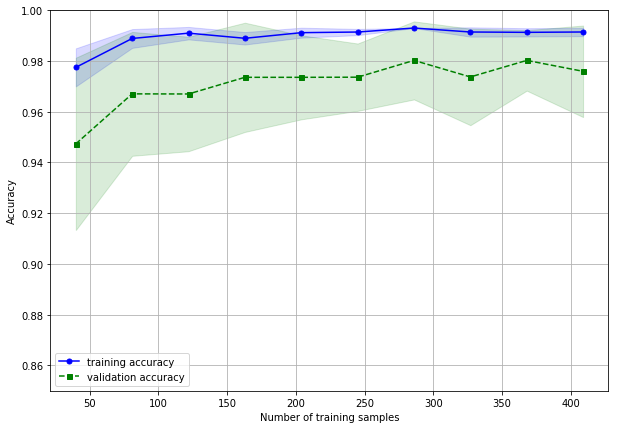

In [5]:
# using learning curve function
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

plt.rc('figure', figsize=(10, 7))

pipe_lr = Pipeline([('scl', StandardScaler()),
                    #('pca', PCA(n_components = 2)),
                    ('clf', LogisticRegression(penalty = 'l2', random_state = 0))])
train_sizes, train_scores, test_scores = \
    learning_curve(estimator = pipe_lr,
                   X = X_train,
                   y = y_train,
                   train_sizes = np.linspace(0.1, 1.0, 10),
                   cv = 10)
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)
plt.plot(train_sizes, train_mean, color = 'blue',
        marker = 'o', markersize = 5,
        label = 'training accuracy')
plt.fill_between(train_sizes, 
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15, color = 'blue')
plt.plot(train_sizes, test_mean, color = 'green',
        marker = 's', markersize = 5,
        linestyle = '--', label = 'validation accuracy')
plt.fill_between(train_sizes, 
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15, color = 'green')
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.ylim([0.85, 1.0])
plt.grid()
plt.show()

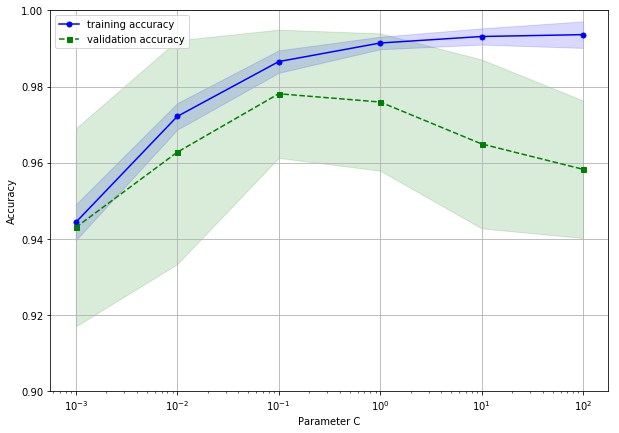

In [6]:
# validation curves
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = \
    validation_curve(estimator = pipe_lr,
                   X = X_train,
                   y = y_train,
                   param_name = 'clf__C',
                   param_range = param_range,
                   cv = 10)
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)
plt.plot(param_range, train_mean, color = 'blue',
        marker = 'o', markersize = 5,
        label = 'training accuracy')
plt.fill_between(param_range, 
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15, color = 'blue')
plt.plot(param_range, test_mean, color = 'green',
        marker = 's', markersize = 5,
        linestyle = '--', label = 'validation accuracy')
plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15, color = 'green')
plt.xlabel('Parameter C')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.ylim([0.9, 1.0])
plt.grid()
plt.show()

In [7]:
# grid search
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('clf', SVC(random_state = 1))])

param_range = np.geomspace(0.0001, 1000.0, 8)
param_grid = [{'clf__C': param_range,
               'clf__kernel': ['linear']},
              {'clf__C': param_range,
               'clf__gamma': param_range,
               'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 10, n_jobs = -1)
gs = gs.fit(X_train, y_train)
print('Best score: %.3f' % gs.best_score_)
print('Best parameters: %s' % gs.best_params_)

# best estimator
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Best score: 0.978
Best parameters: {'clf__C': 0.10000000000000001, 'clf__kernel': 'linear'}
Test accuracy: 0.965


In [8]:
# nested cross-validation
gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 10, n_jobs = -1)

scores = cross_val_score(gs, X, y, scoring = 'accuracy', cv = 5)

print('CV accuracy scores: %s' % (scores))
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [ 0.95652174  0.97391304  0.97345133  0.96460177  0.99115044]
CV accuracy: 0.972 +/- 0.012


In [9]:
# nested cross-validation for a simple decision-tree classifier
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 0),
                 param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                 scoring = 'accuracy', cv = 5)

scores = cross_val_score(gs, X_train, y_train, scoring = 'accuracy', cv = 5)

print('CV accuracy scores: %s' % (scores))
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [ 0.82417582  0.9010989   0.92307692  0.93406593  0.95604396]
CV accuracy: 0.908 +/- 0.045


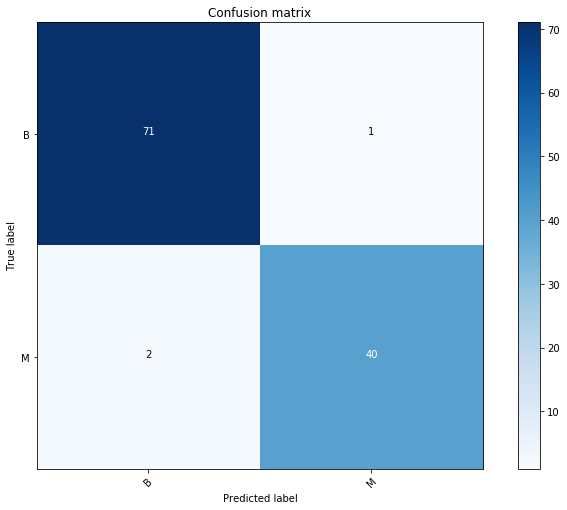

In [10]:
# confusion matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure()
plot_confusion_matrix(cm, le.classes_)
plt.show()

In [11]:
# precision, recall & f1-scores
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer

print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))

# using f1-score with grid-search
gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = make_scorer(f1_score, pos_label = 0),
                  cv = 10, n_jobs = -1)
gs = gs.fit(X_train, y_train)
print('Best F1-score: %.3f' % gs.best_score_)
print('Best parameters: %s' % gs.best_params_)

Precision: 0.976
Recall: 0.952
F1: 0.964
Best F1-score: 0.983
Best parameters: {'clf__C': 0.10000000000000001, 'clf__kernel': 'linear'}
